## SGSC Lava Inference - CPU - fixed point

In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import numpy as np
from lava.proc.lif.process import LIFReset
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg, Loihi2SimCfg
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import opendatasets as od
from SGSC_dataset_loader_padded_spikes import SGSC_Loader

In [3]:
def rescale_factor(w, bits, percentile = 99):
    rng = float(2**(bits-1))
    mx = max(np.percentile(w,percentile), np.percentile(-w,percentile))
    fac = (rng-1)/mx
    mn = -(rng-2)/fac
    return (fac, mn, mx)

In [ ]:
params = {}
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 2.0
params["num_samples"] = 1 #int(11005 / 8)
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)

params["NUM_INPUT"] = 80
params["NUM_HIDDEN"] = 512
params["NUM_OUTPUT"] = 35

# toggle to record spikes, useful for debugging, but memory intensive
params["record_network_ih_activity"] =  True

In [5]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)


In [6]:
x_train, y_train, x_test, y_test, x_validation, y_validation = SGSC_Loader(dir = os.getcwd() + "/spiking-google-speech-commands/",
                                                                           num_samples=params["num_samples"],
                                                                           shuffle = True,
                                                                           shuffle_seed = 0,
                                                                           return_single_sample = 1)

loading training


100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


loading testing


100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]


loading validation


100%|██████████| 1/1 [00:00<00:00, 26051.58it/s]


In [7]:
the_x = x_test
the_y = y_test

In [8]:
# transform some parmeters
tau_mem_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_MEM"])
tau_mem_fac_int = int(np.round(tau_mem_fac*(2**12)))

tau_syn_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_SYN"])
tau_syn_fac_int = int(np.round(tau_syn_fac*(2**12)))

weight_scale = (params["TAU_SYN"] / params["DT_MS"]) * tau_syn_fac

In [9]:
# load connections
w_i2h = np.load("SGSC_pretrained_weights/SGSC_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((80,512)).T
w_i2h *= weight_scale
w_i2h *= tau_mem_fac

w_h2h = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop1-g.npy")
w_h2h = w_h2h.reshape((512,512)).T
w_h2h *= weight_scale
w_h2h *= tau_mem_fac

w_h2o = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((512,35)).T
w_h2o *= weight_scale
w_h2o *= tau_mem_fac

In [10]:
weight_bits= 8

In [11]:
w = np.hstack([w_i2h,w_h2h])
w_2h_fac, mn, mx = rescale_factor(w,weight_bits)
w_i2h[w_i2h > mx] = mx
w_i2h[w_i2h < mn] = mn
w_i2h_int = np.round(w_i2h*w_2h_fac).astype(np.int8)
print(f"i2h: mn == {np.amin(w_i2h_int)}, mx == {np.amax(w_i2h_int)}")

w_h2h[w_h2h > mx] = mx
w_h2h[w_h2h < mn] = mn
w_h2h_int = np.round(w_h2h*w_2h_fac).astype(np.int8)
print(f"h2h: mn == {np.amin(w_h2h_int)}, mx == {np.amax(w_h2h_int)}")

w_2o_fac, mn, mx = rescale_factor(w_h2o,weight_bits)
w_2o_fac /= 2.0
mn *= 2.0
mx *= 2.0
w_h2o[w_h2o > mx] = mx
w_h2o[w_h2o < mn] = mn
w_h2o_int = np.round(w_h2o*w_2o_fac).astype(np.int8)
print(f"h2o: mn == {np.amin(w_h2o_int)}, mx == {np.amax(w_h2o_int)}")

vth_hid = w_2h_fac
vth_hid_int = int(np.round(vth_hid))

i2h: mn == -126, mx == 127
h2h: mn == -48, mx == 35
h2o: mn == -48, mx == 84


In [12]:
sample_image_start = the_x.shape[2] * params["sample_id"]
sample_image_end = (the_x.shape[2] * params["sample_id"]) + the_x.shape[2]

In [13]:
the_x= np.hstack(the_x)
print(the_x.shape)

(80, 2000)


In [14]:
input = RingBuffer(data = the_x)

hidden = LIFReset(shape=(512, ),                         # Number and topological layout of units in the process
                  vth= vth_hid_int,                             # Membrane threshold
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0.0,           # Bias added to the membrane voltage in every timestep
                  name="hidden",
                  reset_interval=2000)

output = LIFReset(shape=(35, ),                         # Number and topological layout of units in the process
                  vth=2**30,                             # Membrane threshold set so it cannot spike
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0.0,           # Bias added to the membrane voltage in every timestep
                  name="output",
                  reset_interval=2000)

in_to_hid = Dense(weights= w_i2h_int,     # Initial value of the weights, chosen randomly
              name='in_to_hid')

hid_to_hid = Dense(weights=w_h2h_int,
                   name='hid_to_hid')

hid_to_out = Dense(weights=w_h2o_int,
                   name= 'hid_to_out')

input.s_out.connect(in_to_hid.s_in)
in_to_hid.a_out.connect(hidden.a_in)
hidden.s_out.connect(hid_to_hid.s_in)
hidden.s_out.connect(hid_to_out.s_in)
hid_to_hid.a_out.connect(hidden.a_in)
hid_to_out.a_out.connect(output.a_in)

if params["record_network_ih_activity"]:
    # monitor outputs
    monitor_input = Monitor()
    monitor_hidden = Monitor()
    monitor_hidden_v = Monitor()

    monitor_hidden_v.probe(hidden.v, the_x.shape[1])

    monitor_input.probe(input.s_out, the_x.shape[1])
    monitor_hidden.probe(hidden.s_out, the_x.shape[1])

monitor_output = Monitor()
monitor_output.probe(output.v, the_x.shape[1])

num_steps = int(2000/params["DT_MS"])
print("number of samples:", params["num_samples"])

# run something
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt") # changed 1 -> 2

n_sample = params.get("num_samples")

number of samples: 1


In [15]:
for i in tqdm(range(the_x.shape[1] // 2000)):
    output.run(condition=run_condition, run_cfg=run_cfg)

output_v = monitor_output.get_data()
good = 0

for i in range(the_x.shape[1] // 2000):
    out_v = output_v["output"]["v"][i*num_steps:(i+1)*num_steps,:]
    sum_v = np.sum(out_v,axis=0)
    pred = np.argmax(sum_v)
    print(f"prediction {pred} vs ground truth {the_y[i]}")
    if pred == the_y[i]:
        good += 1

print(f"test accuracy: {good/n_sample*100}")
#output.stop()

100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


prediction 25 vs ground truth 33
test accuracy: 0.0


In [16]:
output_v["output"]["v"].shape

(2000, 35)

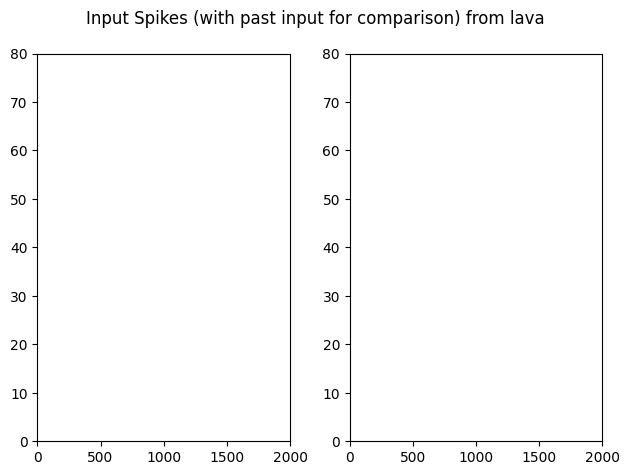

In [17]:
if params["record_network_ih_activity"]:
    # Input spike activity
    input_spikes = monitor_input.get_data()

    process = list(input_spikes.keys())[0]
    spikes_out = list(input_spikes[process].keys())[0]
    input_s = input_spikes[process][spikes_out]

    input_single_image = input_s[sample_image_start:sample_image_end]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Input Spikes (with past input for comparison) from lava')

    for i in range(params["NUM_INPUT"]):
        ax1.scatter(np.where(input_single_image[:,i] > 0)[0], 
                    np.where(input_single_image[:,i] > 0)[0].shape[0] * [i],
                    c = '#1f77b4',
                    s = 2)

    x = np.swapaxes(the_x, 0, 1)[sample_image_start:sample_image_end]
    for i in range(params["NUM_INPUT"]):
        ax2.scatter(np.where(x[:,i] > 0)[0], 
                    np.where(x[:,i] > 0)[0].shape[0] * [i],
                    c = '#1f77b4',
                    s = 2)

    ax1.set_ylim(0, 80)
    ax2.set_ylim(0, 80)
    ax1.set_xlim(0, the_x.shape[1] / params["num_samples"])
    ax2.set_xlim(0, the_x.shape[1] / params["num_samples"])

    fig.tight_layout()

    plt.show()

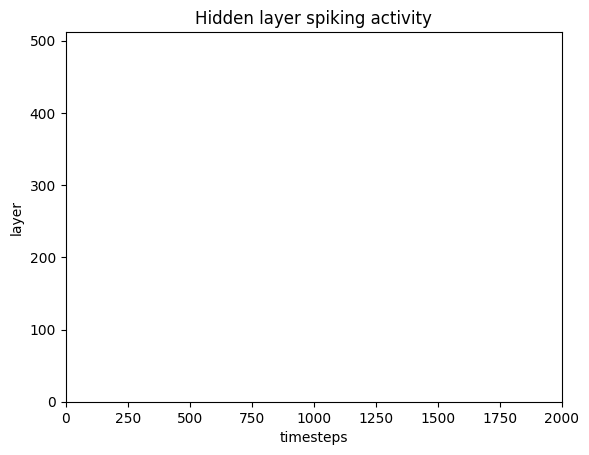

In [18]:
if params["record_network_ih_activity"]:
    # Hidden layer activity 

    hidden_spikes = monitor_hidden.get_data()

    process = list(hidden_spikes.keys())[0]
    spikes_out = list(hidden_spikes[process].keys())[0]
    hidden_s = hidden_spikes[process][spikes_out]

    hidden_single_image = hidden_s[sample_image_start:sample_image_end]

    for i in range(params["NUM_HIDDEN"]):
        plt.scatter(np.where(hidden_single_image[:,i] > 0)[0], 
                    np.where(hidden_single_image[:,i] > 0)[0].shape[0] * [i],
                    c = '#1f77b4',
                    s = 0.5)

    plt.title("Hidden layer spiking activity")
    plt.ylim(0, params["NUM_HIDDEN"])
    plt.xlim(0, the_x.shape[1] / params["num_samples"])
    plt.ylabel("layer")
    plt.xlabel("timesteps")
    plt.show()

In [ ]:
if params["record_network_ih_activity"]:
    # output voltage activity
    # high voltage levels are explained by a mega high threshold, to enable non-spiking
    hidden_voltage = monitor_hidden_v.get_data()

    process = list(hidden_voltage.keys())[0]
    spikes_out = list(hidden_voltage[process].keys())[0]
    hidden_v = hidden_voltage[process][spikes_out]

    single_image = hidden_v[sample_image_start:sample_image_end]
    plt.figure(figsize=(12, 3), dpi=80)
    for i in range(params["NUM_OUTPUT"]):
        if i == 16:
            plt.plot(single_image[:,i] / 64 / (2 ** weight_bits / 2)) 
        
    plt.title("Hidden layer voltage activity")
    plt.ylabel("voltage (v)")
    plt.xlabel("timesteps")
    plt.xlim(0, the_x.shape[1] / params["num_samples"])
    plt.xlim(450, 600)
    plt.show()

In [ ]:
if params["record_network_ih_activity"]:
    # output voltage activity
    # high voltage levels are explained by a mega high threshold, to enable non-spiking
    output_voltage = monitor_output.get_data()

    process = list(output_voltage.keys())[0]
    spikes_out = list(output_voltage[process].keys())[0]
    output_v = output_voltage[process][spikes_out]

    single_image = output_v[sample_image_start:sample_image_end]
    plt.figure(figsize=(12, 3), dpi=80)
    for i in range(params["NUM_OUTPUT"]):
        plt.plot(single_image[:,i] / 64)

    plt.title("Output layer voltage activity")
    plt.ylabel("voltage (v)")
    plt.xlabel("timesteps")
    #plt.xlim(0, the_x.shape[1] / params["num_samples"])
    #plt.xlim(500, 600)

    plt.show()

In [ ]:
if params["record_network_ih_activity"]:
    # output voltage activity
    # high voltage levels are explained by a mega high threshold, to enable non-spiking
    output_voltage = monitor_output.get_data()

    process = list(output_voltage.keys())[0]
    spikes_out = list(output_voltage[process].keys())[0]
    output_v = output_voltage[process][spikes_out]

    single_image = output_v[sample_image_start:sample_image_end]
    plt.figure(figsize=(12, 3), dpi=80)
    for i in range(params["NUM_OUTPUT"]):
        if i == 16:
            plt.plot(single_image[:,i] / 64)

    plt.title("Output layer voltage activity")
    plt.ylabel("voltage (v)")
    plt.xlabel("timesteps")
    #plt.xlim(0, the_x.shape[1] / params["num_samples"])
    #plt.xlim(500, 600)

    plt.show()